In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import time 
import math
import sys

Part 1: Screen detection
================

In [3]:
#this function take the center of the image 
def resize(im):
    x = im.shape[0]
    y = im.shape[1]
    return im[int(x/3):int(2*x/3), int(y/3):int(2*y/3)]

In [72]:
def find_screen(cnts, image):
    total = 0
    approx_tmp = 0
    approx = []
    # loop over the contours
    for c in cnts:
        # approximate the contour
        peri = cv2.arcLength(c, True)
        print("perimetre ", peri)
        approx_tmp = cv2.approxPolyDP(c, 0.02 * peri, True)
        approx_tmp = np.squeeze(approx_tmp)
        #print(approx)
        cv2.drawContours(image, [approx_tmp], -1, (0, 255, 0), 4)
        #print(approx_tmp)
        #print(len(approx_tmp))
        if (peri > 100 and peri < 500):
            approx.append(approx_tmp)
            #print(approx)
            cv2.drawContours(image, [approx_tmp], -1, (0, 255, 0), 4)
    plt.imshow(image)
    plt.show()
    #print(approx)
    #print(len(approx))
    return approx

In [5]:
def bords(approx):
    if(len(approx) == 2):
        approx = np.concatenate((approx[0], approx[1]), axis = 0)
    approx = np.squeeze(approx)
    bord = []
    min_x = sys.maxsize
    max_x = 0
    min_y = sys.maxsize
    max_y = 0
    config = -1
    for appro in approx:
        if appro[0] > max_x:
            max_x = appro[0]
        if appro[0] < min_x:
            min_x = appro[0]
        if appro[1] > max_y:
            max_y = appro[1]
        if appro[1] < min_y:
            min_y = appro[1]
    
    bord.extend([min_x, max_x, min_y, max_y])
    
    if(len(approx) == 4):
        if(max_x - min_x > max_y - min_y):
            config = 2
        else:
            config = 1
    else:
        approx_x = approx[:,0]
        approx_y = approx[:,1]
        fit = np.polyfit(approx_x,approx_y,1)
        if(fit[0] < 0):
            config = 3
        else: 
            config = 4
    return bord,config

In [71]:
def detection(path):
    start_time = time.time()
    if(type(path) == str):
        img = cv2.imread(path)
        path = img
    img = resize(path)
    #on split l'image en fonction des couleurs 
    b,g,r = cv2.split(img)
    
    print("--- %s seconds ---" % (time.time() - start_time))

    # on parcours l'image et on mets r a 0 si b ou r superieur a un seuil (ici 50)
    for x in range(0, r.shape[0]):
        for y in range(0, r.shape[1]):
            if(b[x][y] > 50 or g[x][y] > 50):
                r[x][y] = 0

    print("--- %s seconds ---" % (time.time() - start_time))

    # on applique un filtre binaire 
    ret,seg_red = cv2.threshold(r,190,255.0,cv2.THRESH_BINARY)

    # detecte 
    edged = cv2.Canny(seg_red, 100, 100)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)
    
    im2, cnts, hierarchy = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    plt.imshow(closed)
    plt.show()

    approx = find_screen(cnts, img)

    bord,config = bords(approx)
    
    plt.imshow(img)
    plt.show()
    sucess = 1
    
    print("les 4 bords de l'ecrans sont : ", bord)
    print("la configuration est la n°", config)
    print("--- %s seconds ---" % (time.time() - start_time))
    
    return bord,config,sucess
    

In [7]:
bord1, config1, sucss = detection('screen_red1.png')

--- 0.1589040756225586 seconds ---
--- 0.8963689804077148 seconds ---
perimetre  250.04163002967834
les 4 bords de l'ecrans sont :  [179, 231, 149, 220]
la configuration est la n° 1
--- 0.9005780220031738 seconds ---


In [8]:
bord2, config2, s = detection('screen_red2.png')

--- 0.08689689636230469 seconds ---
--- 0.8575010299682617 seconds ---
perimetre  251.21320295333862
les 4 bords de l'ecrans sont :  [149, 221, 166, 219]
la configuration est la n° 2
--- 0.8609218597412109 seconds ---


In [9]:
bord3, config3, s = detection('screen_red3.png')

--- 0.08750367164611816 seconds ---
--- 0.9080958366394043 seconds ---
perimetre  185.55634891986847
perimetre  176.3847759962082
les 4 bords de l'ecrans sont :  [117, 232, 150, 222]
la configuration est la n° 3
--- 1.0070199966430664 seconds ---


In [10]:
bord4, config4, s = detection('screen_red4.png')

--- 0.06696796417236328 seconds ---
--- 0.7979578971862793 seconds ---
perimetre  184.97056245803833
perimetre  175.79898953437805
les 4 bords de l'ecrans sont :  [150, 221, 169, 283]
la configuration est la n° 4
--- 0.8020408153533936 seconds ---


Part 2: Color detection
================

In [67]:
def color_detection (bord, config, path):
    if(type(path) == str):
        img = cv2.imread(path)
        path = img
    elif(path == None):
        return 'end'
    
    img = resize(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
    # bords = [min_x, max_x, min_y, max_y]
    
    im1 = []
    im2 = []
    colors1 = []
    colors2 = []
    # ========================= A Verifier ======================
    (min_y, max_y, min_x, max_x) = bord
    #(min_x, max_x, min_y, max_y) = bord
    mid_x = int( min_x + (max_x - min_x)/2)
    mid_y = int( min_y + (max_y - min_y)/2)
    
    #print("min x : ", min_x, " max_x : ", max_x, " min y: ", min_y, " max y: ", max_y)
    if(config == 2):
        #Image dans la hauteur - ie 
        im1 = img[min_x: max_x, min_y: mid_y ]
        im2 = img[min_x: max_x , mid_y:max_y ]
    elif(config == 1):
        #Image dans la Longeur - ie 
        im1 = img[min_x : mid_x , min_y:max_y]
        im2 = img[mid_x : max_x, min_y:max_y]
    elif(config == 3): 
        #Image dans  - ie 
        im1 = img[min_x : mid_x, mid_y : max_y]
        im2 = img[mid_x : max_x, min_y : mid_y]
    elif(config == 4): 
        #Image dans  - ie 
        im1 = img[min_x : mid_x , min_y : mid_y]
        im2 = img[mid_x : max_x, mid_y : max_y]
    
    
    
    colors1 = cutting(im1, 3, 3)
    colors2 = cutting(im2, 3, 3)
    if(colors1 == colors2):
        return colors1
    else:
        print("Error 1 : ", colors1)
        print("Error 2 : ", colors2)
        print("Image 1")
        plt.imshow(im1)
        plt.show()

        print("Image 2")
        plt.imshow(im2)
        plt.show()
        return 'error'
    

In [12]:
# this function take an image and two index, 
def cutting(img, indexX, indexY):
    colors = []
    x = img.shape[0]
    y = img.shape[1]
    for i in range(0, indexX):
        #print("Index of i:", i)
        for j in range(0, indexY):
            #print("Index of j:", j)
            imTmp = img[int((i)*x/indexX):int((i+1)*x/indexX), int((j)*y/indexY):int((j+1)*y/indexY)]
            #plt.imshow(imTmp)
            #plt.show()
            color = find_color(imTmp)
            colors.append(color)
    return colors

In [29]:
rgb_dictionary = {
    #
    (255,0,0): 'red',
    (0,255,0):'green', 
    #(0,255,250):'blue_cian',
    (0,0,255): 'blue'
    #(255, 255,0): 'yellow',
    #(255, 0, 255): 'Magenta', 
    #(255, 255, 255): 'white', 
    #(0,0,0): 'black' 
}

In [14]:
#This function 
def distance(c1, c2):
    (r1,g1,b1) = c1
    (r2,g2,b2) = c2
    return math.sqrt((r1 - r2)**2 + (g1 - g2) ** 2 + (b1 - b2) **2)

In [15]:
# this function take a point and find its color 
def witch_color(point):
    colors = list(rgb_dictionary.keys())
    closest_colors = sorted(colors, key=lambda color: distance(color, point))
    closest_color = closest_colors[0]
    code = rgb_dictionary[closest_color]
    return code

In [16]:
# this function take an square and output its color 
def find_color(img):
    #plt.imshow(img)
    #plt.show()
    x = img.shape[0]
    y = img.shape[1]
    mid = img[int(x/2), int(y/2)]
    return witch_color(mid)

In [17]:
start_time = time.time()

print(color_detection(bord3, config3, 'color_screen3.png'))
print("--- %s seconds ---" % (time.time() - start_time))


['red', 'green', 'blue', 'green', 'blue', 'red', 'blue', 'red', 'green']
--- 0.10211300849914551 seconds ---


Part 3: From Video
================

--- 0.003443002700805664 seconds ---
--- 0.7521400451660156 seconds ---


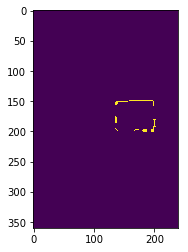

perimetre  231.11269795894623


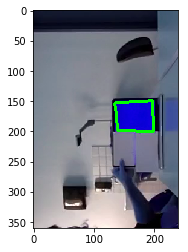

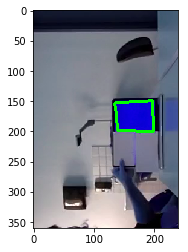

les 4 bords de l'ecrans sont :  [135, 199, 149, 200]
la configuration est la n° 2
--- 2.2252070903778076 seconds ---
screen detection 1
discard
discard
discard
discard
discard
discard


/Users/veroniquegranoux/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
color :  ['red', 'green', 'blue', 'blue', 'red', 'green', 'green', 'blue', 'red']
discard
discard
discar

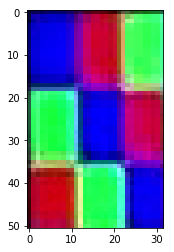

Image 2


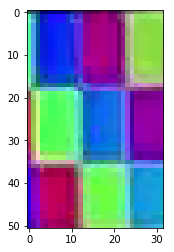

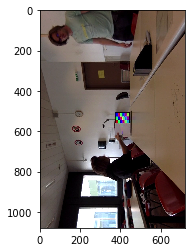

color :  ['blue', 'red', 'green', 'green', 'blue', 'red', 'red', 'green', 'blue']
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
Error 1 :  ['red', 'green', 'blue', 'blue', 'red', 'green', 'green', 'blue', 'red']
Error 2 :  ['red', 'green', 'green', 'blue', 'blue', 'green', 'green', 'blue', 'blue']
Image 1


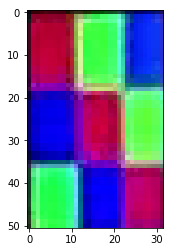

Image 2


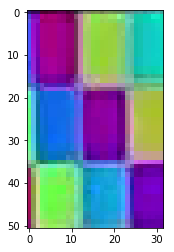

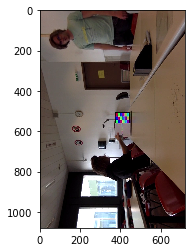

color :  ['red', 'green', 'blue', 'blue', 'red', 'green', 'green', 'blue', 'red']
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
color :  ['green', 'blue', 'red', 'red', 'green', 'blue', 'blue', 'red', 'green']
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
Error 1 :  ['blue', 'red', 'green', 'green', 'blue', 'blue', 'red', 'green', 'blue']
Error 2 :  ['blue', 'blue', 'red', 'green', 'green', 'blue', 'blue', 'red', 'green']
Image 1


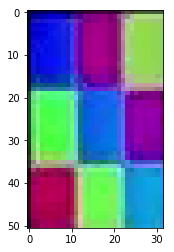

Image 2


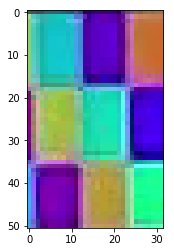

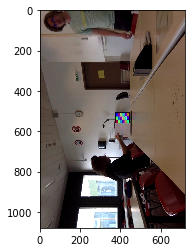

color :  ['blue', 'red', 'green', 'green', 'blue', 'red', 'red', 'green', 'blue']
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
Error 1 :  ['red', 'green', 'green', 'blue', 'blue', 'green', 'green', 'blue', 'blue']
Error 2 :  ['blue', 'red', 'green', 'green', 'blue', 'red', 'red', 'green', 'blue']
Image 1


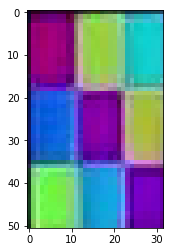

Image 2


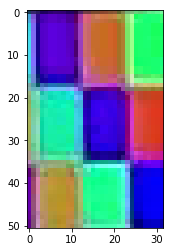

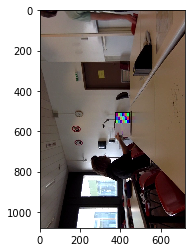

color :  ['red', 'green', 'blue', 'blue', 'red', 'green', 'green', 'blue', 'red']
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
Error 1 :  ['green', 'green', 'blue', 'blue', 'red', 'green', 'blue', 'blue', 'red']
Error 2 :  ['red', 'green', 'blue', 'blue', 'red', 'green', 'green', 'blue', 'red']
Image 1


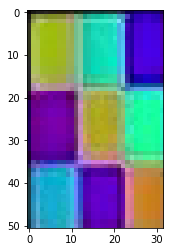

Image 2


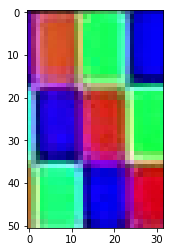

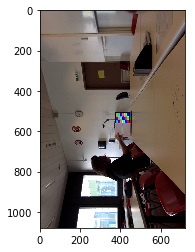

color :  ['green', 'blue', 'red', 'red', 'green', 'blue', 'blue', 'red', 'green']
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
color :  ['blue', 'red', 'green', 'green', 'blue', 'red', 'red', 'green', 'blue']
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
Error 1 :  ['red', 'green', 'blue', 'blue', 'red', 'green', 'green', 'blue', 'red']
Error 2 :  ['red', 'green', 'blue', 'blue', 'red', 'green', 'green', 'blue', 'blue']
Image 1


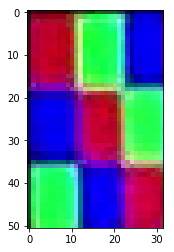

Image 2


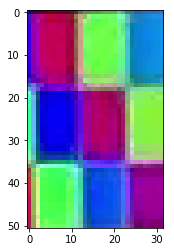

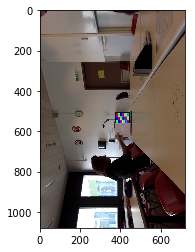

color :  ['red', 'green', 'blue', 'blue', 'red', 'green', 'green', 'blue', 'red']
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
Error 1 :  ['green', 'blue', 'red', 'red', 'green', 'blue', 'blue', 'red', 'green']
Error 2 :  ['green', 'blue', 'blue', 'red', 'green', 'blue', 'blue', 'red', 'green']
Image 1


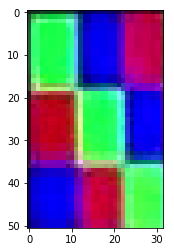

Image 2


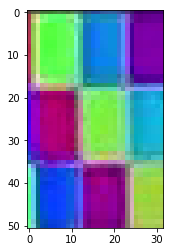

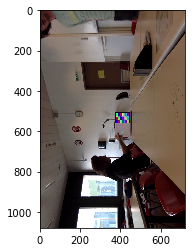

color :  ['green', 'blue', 'red', 'red', 'green', 'blue', 'blue', 'red', 'green']
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
discard
color :  ['blue', 'red', 'green', 'green', 'blue', 'red', 'red', 'green', 'blue']
discard
discard
----END----
397
[['red', 'green', 'blue', 'blue', 'red', 'green', 'green', 'blue', 'red'], ['green', 'blue', 'red', 'red', 'green', 'blue', 'blue', 'red', 'green'], ['blue', 'red', 'green', 'green', 'blue', 'red', 'red', 'green', 'blue'], ['red', 'green', 'blue', 'blue', 'red', 'green', 'green', 'blue', 'red'], ['green', 'blue', 'red', 'red', 'green', 'blue', 'blue', 'red', 'green'], ['blue', 'red', 'green', 'green', 'blue', 'red', 'red', 'green', 'blue'], ['red', 'green', 'blue', 'blue', 'red', 'green', 'green', 'blue', 'red'], ['green', 'blue', 'red', 'red', 'green', 'blue', 'blue', 'red', 'green'], ['blue', 'red', 'green', 'g

In [77]:
start_time = time.time()
vidcap = cv2.VideoCapture('final2_short.mp4')
success,image = vidcap.read()
count = 0
screen_detected = 0
error = 0
config = -1
bord = []
colors = []
color_prev = ['red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red']
success = True
while success:
    success,image = vidcap.read()
    if(count < 0):
        print("wait")
    elif(screen_detected == 0):
        bord, config, screen_detected = detection(image) 
        print("screen detection", screen_detected)
    else:
        color = color_detection(bord, config, image)
        if (color == color_prev):
            print("discard")
        elif(color == 'end'):
            print('----END----')
            break
        elif(color == None or color == 'error'):
            error = error + 1
            if(error > 10):
                break
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
            plt.imshow(image)
            plt.show()
        else:
            print("color : ", color)
            colors.append(color)
            color_prev = color
    count += 1
print(count)
print(colors)
print("--- %s seconds ---" % (time.time() - start_time))